c:\Users\hasan\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded processed dataset: (10041, 25)
Features: 21 columns
Loaded edges.npy with shape: torch.Size([2, 20054])
Data(x=[10041, 21], edge_index=[2, 20054], y=[10041])
Train/Val/Test: 6425 1607 2009
Epoch 001 | Train loss: 0.7003 | Val loss: 0.6083 | Train acc: 0.6237 | Val acc: 0.7810
Epoch 020 | Train loss: 0.4344 | Val loss: 0.3713 | Train acc: 0.8289 | Val acc: 0.8494
Epoch 040 | Train loss: 0.3634 | Val loss: 0.2413 | Train acc: 0.8553 | Val acc: 0.8936
Epoch 060 | Train loss: 0.3159 | Val loss: 0.2090 | Train acc: 0.8725 | Val acc: 0.9085
Epoch 080 | Train loss: 0.2865 | Val loss: 0.1828 | Train acc: 0.8887 | Val acc: 0.9222
Epoch 100 | Train loss: 0.2659 | Val loss: 0.1621 | Train acc: 0.8920 | Val acc: 0.9334
Epoch 120 | Train loss: 0.2575 | Val loss: 0.1554 | Train acc: 0.8981 | Val acc: 0.9328
Epoch 140 | Train loss: 0.2568 | Val loss: 0.1486 | Train acc: 0.8973 | Val acc: 0.9384
Epoch 160 | Train loss: 0.2507 | Val loss: 0.1415 | Train acc: 0.8991 | Val acc: 0.9465
Epoch 180 | 

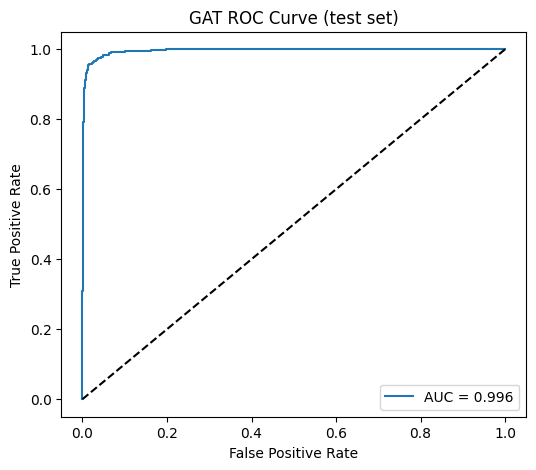

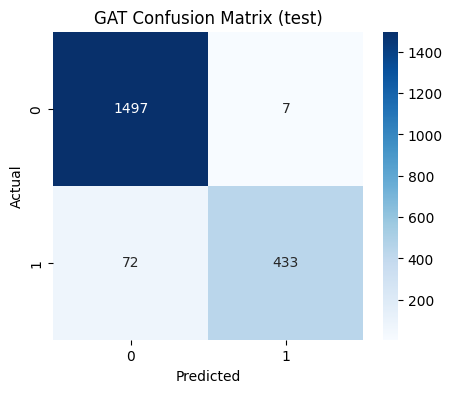

Saved metrics to: ..\results\gat_metrics.csv
GNN training & evaluation complete.


In [1]:
# 06_GNN_Model.ipynb
# Graph Neural Network training & evaluation (GAT) for CrimeNet

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, roc_curve)
from sklearn.neighbors import NearestNeighbors

# ----------------------
# Paths & dirs
# ----------------------
DATA_PROC = Path("../data/processed/crime_district_processed.csv")
EDGES_FILE = Path("../data/edges.npy")
MODELS_DIR = Path("../models")
RESULTS_DIR = Path("../results")

MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# ----------------------
# Load processed data
# ----------------------
if not DATA_PROC.exists():
    raise FileNotFoundError(f"Processed dataset not found: {DATA_PROC} — run preprocessing notebooks first.")

df = pd.read_csv(DATA_PROC)
print("Loaded processed dataset:", df.shape)

# Basic check: district column
if "district" not in df.columns:
    # If district missing, create index-based district id
    df = df.reset_index().rename(columns={"index":"district"})

# Target: is_hotspot
if "is_hotspot" not in df.columns:
    thr = df["total_ipc_crimes_mean"].quantile(0.75)
    df["is_hotspot"] = (df["total_ipc_crimes_mean"] >= thr).astype(int)
    print("Created 'is_hotspot' with threshold:", thr)

# ----------------------
# Feature matrix
# ----------------------
# Select numeric columns except identifiers and target
exclude = {"district", "district_id", "year", "is_hotspot"}
feature_cols = [c for c in df.columns if c not in exclude and df[c].dtype in [int, float]]
X = df[feature_cols].fillna(0).values
y = df["is_hotspot"].astype(int).values
district_names = df["district"].astype(str).tolist()

print("Features:", len(feature_cols), "columns")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----------------------
# Build edges: load edges.npy if exists, else k-NN on features
# ----------------------
if EDGES_FILE.exists():
    raw_edges = np.load(EDGES_FILE, allow_pickle=True)
    # raw_edges may be list of tuples; convert to directed edge_index
    edges = []
    for e in raw_edges:
        edges.append([int(e[0]), int(e[1])])
        edges.append([int(e[1]), int(e[0])])
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    print("Loaded edges.npy with shape:", edge_index.shape)
else:
    # fallback: k-NN graph on features (cosine)
    k = 8
    nbrs = NearestNeighbors(n_neighbors=min(k+1, X_scaled.shape[0]), metric="cosine").fit(X_scaled)
    dists, inds = nbrs.kneighbors(X_scaled)
    edges = []
    for i in range(X_scaled.shape[0]):
        for j in inds[i][1:]:
            edges.append([i, int(j)])
            edges.append([int(j), i])
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    print("Built k-NN edge_index with shape:", edge_index.shape)

# ----------------------
# Build PyG data object
# ----------------------
x = torch.tensor(X_scaled, dtype=torch.float)
y_t = torch.tensor(y, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y_t)
print(data)

# ----------------------
# Train/Val/Test split - node-level stratified
# ----------------------
num_nodes = data.num_nodes
idx = np.arange(num_nodes)
# If only one class present, stratify will fail — handle it
if len(np.unique(y)) > 1:
    train_idx, test_idx = train_test_split(idx, test_size=0.2, stratify=y, random_state=42)
    train_idx, val_idx = train_test_split(train_idx, test_size=0.2, stratify=y[train_idx], random_state=42)
else:
    # fallback random splits
    train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)
    train_idx, val_idx = train_test_split(train_idx, test_size=0.2, random_state=42)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask   = torch.zeros(num_nodes, dtype=torch.bool)
test_mask  = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print("Train/Val/Test:", train_mask.sum().item(), val_mask.sum().item(), test_mask.sum().item())

# ----------------------
# Define GAT model
# ----------------------
class GATNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels=64, out_channels=2, heads=4, dropout=0.3):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GATNet(in_channels=data.num_node_features, hidden_channels=64, out_channels=2, heads=4, dropout=0.3).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# ----------------------
# Training loop with early stopping (patience)
# ----------------------
best_val_loss = float("inf")
best_state = None
patience = 40
patience_counter = 0
num_epochs = 400

for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    # guard against NaN loss
    if not torch.isfinite(loss):
        print(f"NaN/inf loss at epoch {epoch}, stopping.")
        break
    loss.backward()
    optimizer.step()

    # validation
    model.eval()
    with torch.no_grad():
        val_out = model(data.x, data.edge_index)
        val_loss = float(criterion(val_out[data.val_mask], data.y[data.val_mask]).cpu().item())

    if val_loss < best_val_loss - 1e-7:
        best_val_loss = val_loss
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1

    if epoch % 20 == 0 or epoch == 1:
        train_pred = out[data.train_mask].argmax(dim=1).cpu().numpy()
        val_pred = val_out[data.val_mask].argmax(dim=1).cpu().numpy()
        train_acc = accuracy_score(data.y[data.train_mask].cpu().numpy(), train_pred)
        val_acc = accuracy_score(data.y[data.val_mask].cpu().numpy(), val_pred)
        print(f"Epoch {epoch:03d} | Train loss: {loss.item():.4f} | Val loss: {val_loss:.4f} | Train acc: {train_acc:.4f} | Val acc: {val_acc:.4f}")

    if patience_counter >= patience:
        print("Early stopping at epoch", epoch)
        break

# Load best model state
if best_state is not None:
    model.load_state_dict(best_state)
torch.save(model.state_dict(), MODELS_DIR / "best_gat_district.pt")
print("Saved best GAT model to:", MODELS_DIR / "best_gat_district.pt")

# ----------------------
# Final evaluation on test set
# ----------------------
model.eval()
with torch.no_grad():
    logits = model(data.x, data.edge_index).cpu()
    probs_all = F.softmax(logits, dim=1).numpy()  # shape [num_nodes, 2]
    preds_all = logits.argmax(dim=1).numpy()
    y_all = data.y.cpu().numpy()

test_mask_np = data.test_mask.cpu().numpy()
y_test = y_all[test_mask_np]
y_pred = preds_all[test_mask_np]
y_score = probs_all[test_mask_np, 1] if probs_all.shape[1] > 1 else np.zeros_like(y_pred)

# sanitize probabilities
y_score = np.nan_to_num(y_score, nan=0.0, posinf=1.0, neginf=0.0)

# metrics (handle single-class cases gracefully)
acc = accuracy_score(y_test, y_pred) if len(y_test) > 0 else float("nan")
prec = precision_score(y_test, y_pred, zero_division=0) if len(y_test) > 0 else float("nan")
rec = recall_score(y_test, y_pred, zero_division=0) if len(y_test) > 0 else float("nan")
f1 = f1_score(y_test, y_pred, zero_division=0) if len(y_test) > 0 else float("nan")
auc = roc_auc_score(y_test, y_score) if (len(np.unique(y_test)) > 1) else float("nan")
cm = confusion_matrix(y_test, y_pred) if len(y_test) > 0 else np.array([[0,0],[0,0]])

print("\n--- GAT Test Metrics ---")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {auc if not np.isnan(auc) else 'N/A'}")
print("Confusion matrix:\n", cm)

# Save predictions
pred_df = pd.DataFrame({
    "district": district_names,
    "label": y_all,
    "pred": preds_all,
    "prob": probs_all[:, 1] if probs_all.shape[1] > 1 else probs_all[:, 0]
})
pred_df.to_csv(DATA_PROC.parent / "gnn_district_predictions.csv", index=False)
print("Saved predictions to:", DATA_PROC.parent / "gnn_district_predictions.csv")

# ----------------------
# Plots: ROC, Confusion matrix
# ----------------------
if not np.isnan(auc):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("GAT ROC Curve (test set)")
    plt.legend()
    plt.show()

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("GAT Confusion Matrix (test)")
plt.show()

# ----------------------
# Save numeric metrics to results
# ----------------------
metrics = {
    "model": "GAT",
    "accuracy": float(acc),
    "precision": float(prec),
    "recall": float(rec),
    "f1": float(f1),
    "auc": float(auc) if not np.isnan(auc) else None,
    "tp": int(cm[1,1]) if cm.shape==(2,2) else None,
    "tn": int(cm[0,0]) if cm.shape==(2,2) else None,
    "fp": int(cm[0,1]) if cm.shape==(2,2) else None,
    "fn": int(cm[1,0]) if cm.shape==(2,2) else None
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(RESULTS_DIR / "gat_metrics.csv", index=False)
print("Saved metrics to:", RESULTS_DIR / "gat_metrics.csv")

# ----------------------
# End
# ----------------------
print("GNN training & evaluation complete.")
